In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Timestamp, date_range
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts



In [3]:
url='https://raw.githubusercontent.com/Jurk06/Gas_cylinder_price/main/cylinder%20price-1%20-%20Sheet1.csv'
df=pd.read_csv(url)
df.head()

,date,price
0,19-04-18,670.5
1,02-06-18,584.5
2,15-07-18,616.0
3,23-08-18,620.5
4,06-09-18,621.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    34 non-null     object 
 1   price   34 non-null     float64
dtypes: float64(1), object(1)
memory usage: 672.0+ bytes


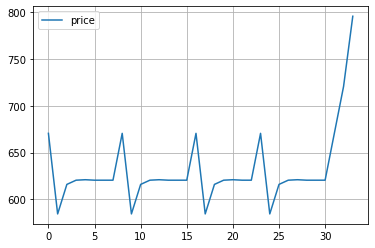

In [6]:
df.plot(grid=True)

In [7]:
df=df.set_index('date')

In [8]:
df.head()

,price
date,
19-04-18,670.5
02-06-18,584.5
15-07-18,616.0
23-08-18,620.5
06-09-18,621.0


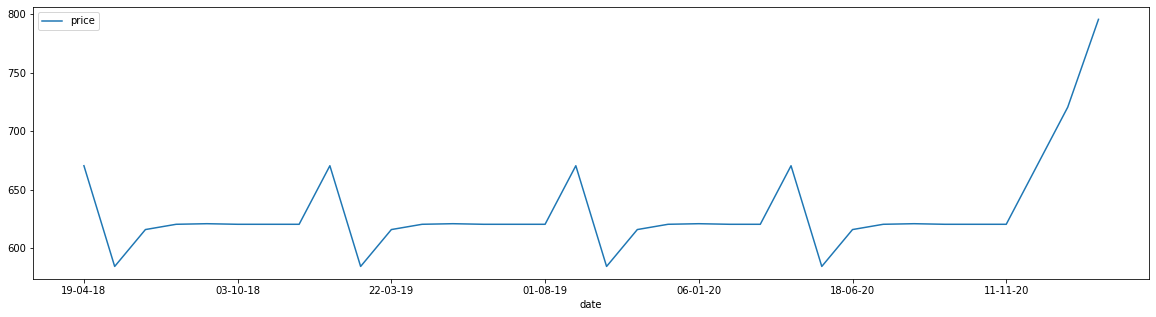

In [12]:
df.plot(figsize=(20,5))

[]

<Figure size 1440x360 with 0 Axes>

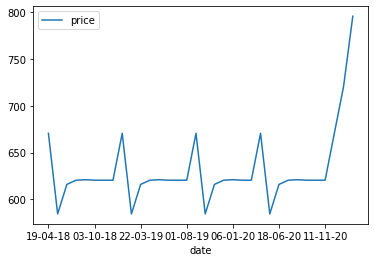

In [14]:
plt.figure(figsize=(20,5))
df.plot()
plt.plot()

In [15]:
df.count()

price    34
dtype: int64

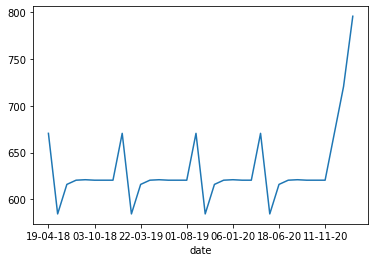

In [18]:
df['price'].plot()
plt.show()

In [19]:
df.describe()

,price
count,34.000000
mean,631.235294
std,40.628628
min,584.500000
25%,620.500000
50%,620.500000
75%,621.000000
max,795.500000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


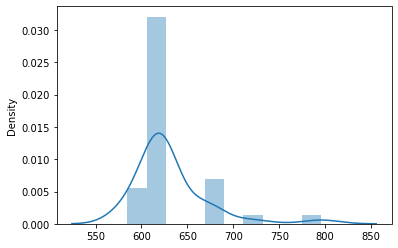

In [24]:
sns.distplot(df,hist=True, bins=10)
plt.show()

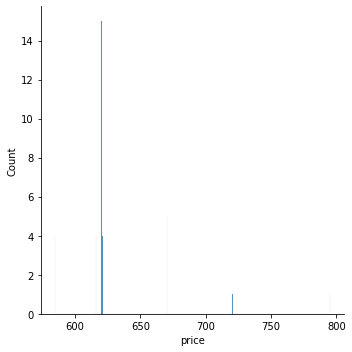

In [30]:
sns.displot(df.price)

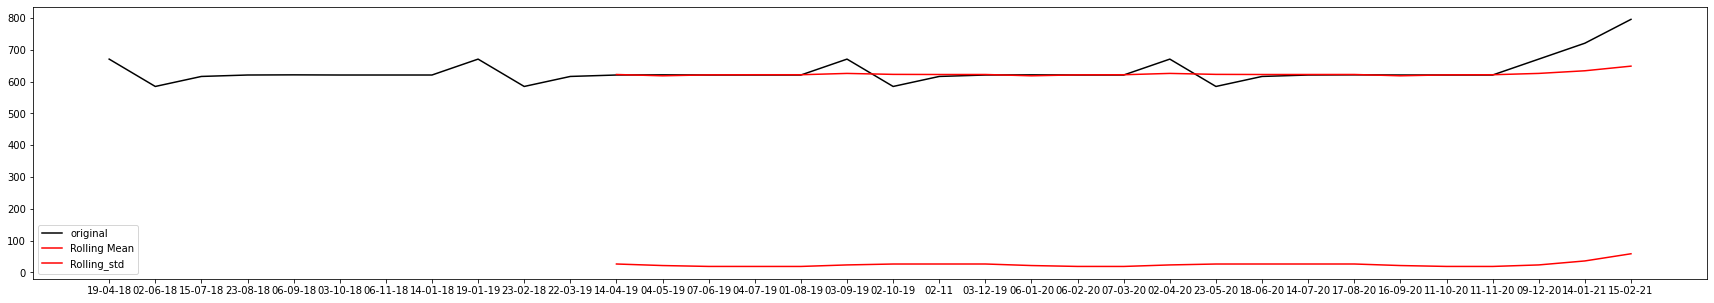

In [32]:
rolling_mean=df['price'].rolling(window=12).mean()
rolling_std=df['price'].rolling(window=12).std()

plt.figure(figsize=(30,5))
plt.plot(df['price'],color='black',label='original')
plt.plot(rolling_mean,color='red', label='Rolling Mean')
plt.plot(rolling_std, color='red', label='Rolling_std')
plt.legend(loc='best')
plt.show()

In [42]:
result=adfuller(df['price'])
print("ADF statics:{}".format(result[0]))
print("p-value: {}".format(result[1]))
print("critical value")
for key,value in result[4].items():
  print('\t{}: {}'.format(key,value))

ADF statics:0.4445930603291246
p-value: 0.9830881139862059
critical value
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


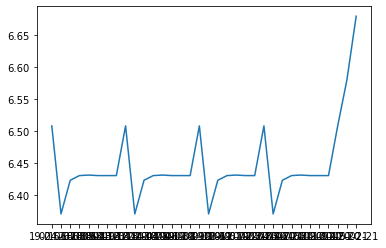

In [44]:
df_log=np.log(df['price'])
plt.plot(df_log)

In [47]:
result=adfuller(df_log)
print("ADF statitics:{}".format(result[0]))
print("p-value:{}".format(result[1]))
print("critical value")
for key,value in result[4].items():
  print("\t{}: {}".format(key,value))

ADF statitics:0.07359354707170421
p-value:0.9642112663917672
critical value
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


In [51]:
def get_stationary(timeseries):
  rolling_mean=timeseries.rolling(window=12).mean()
  rolling_std=timeseries.rolling(window=12).std()

  plt.figure(figsize=(15,5))
  original=plt.plot(timeseries,color="red", label="Original")
  mean=plt.plot(rolling_mean, color="blue", label="Mean")
  std=plt.plot(rolling_std, color="black", label="std")
  plt.title("Rolling Mean and std")
  plt.legend(loc="best")
  plt.show(block=False)

  result=adfuller(timeseries)
  print("ADF statics: {}".format(result[0]))
  print("p-value: {}".format(result[1]))
  print("Critical value")
  for key, value in result[4].items():
    print("\t{}: {}".format(key, value))


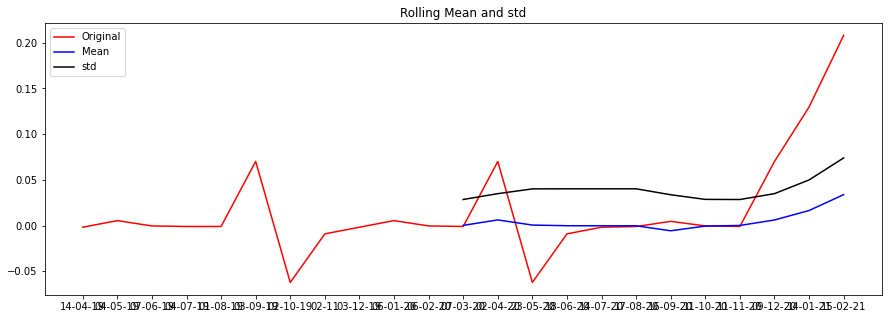

ADF statics: -3.0789970856165993
p-value: 0.028147049425307887
Critical value
	1%: -4.068853732362312
	5%: -3.1271488757396453
	10%: -2.7017297633136095


In [52]:
rolling_mean=df_log.rolling(window=12).mean()
df_log_minus=df_log-rolling_mean
df_log_minus.dropna(inplace=True)
get_stationary(df_log_minus)

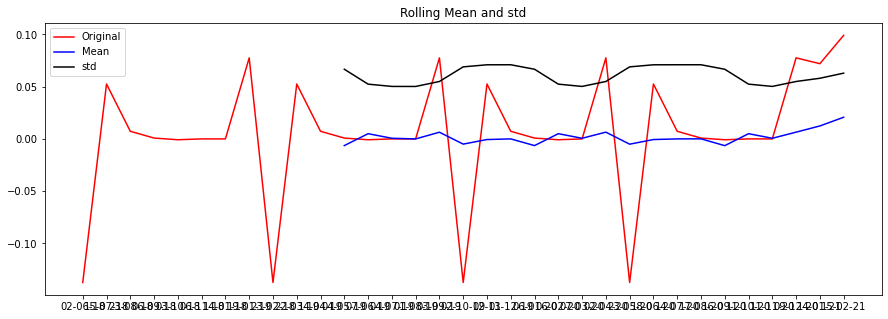

ADF statics: -9.019235358551217
p-value: 5.836198978698736e-15
Critical value
	1%: -3.653519805908203
	5%: -2.9572185644531253
	10%: -2.6175881640625


In [53]:
df_log_shift=df_log-df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationary(df_log_shift)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


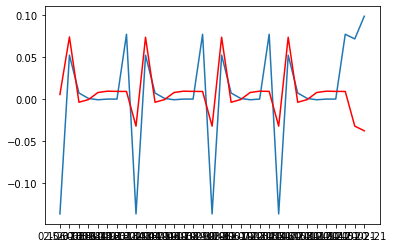

In [54]:
model=ARIMA(df_log,order=(2,1,0))
result=model.fit(disp=1)
plt.plot(df_log_shift)
plt.plot(result.fittedvalues, color='red')

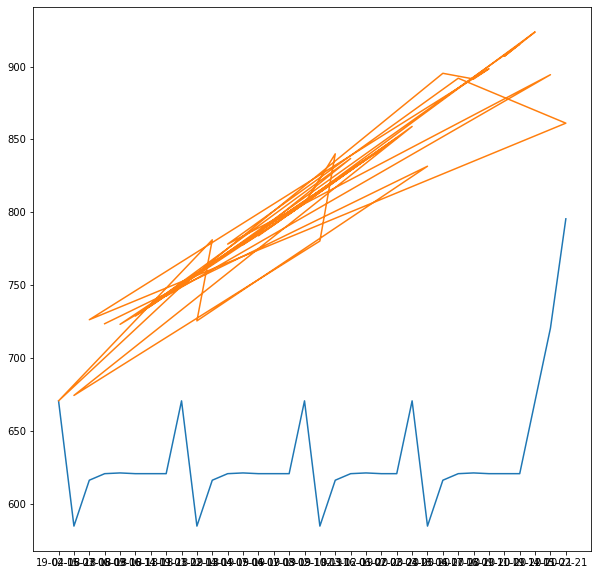

In [55]:
predictions_ARIMA_diff=pd.Series(result.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum=predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log=pd.Series(df_log.iloc[0], index=df_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
prediction_ARIMA=np.exp(predictions_ARIMA_log)
plt.figure(figsize=(10,10))
plt.plot(df['price'])
plt.plot(prediction_ARIMA)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


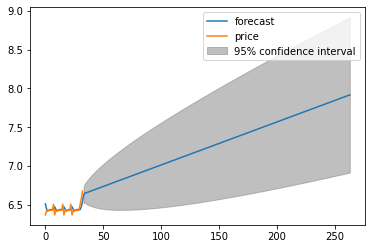

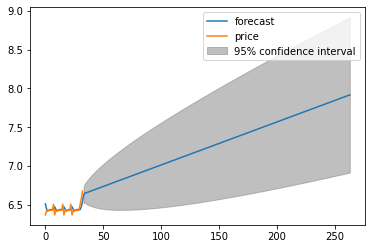

In [56]:
result.plot_predict(1,264)
